<a href="https://colab.research.google.com/github/Konstantin-Larionov/ds_sb_2020_homework/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обзор зарплат аналитиков данных

В данном датасете представлены вакансии аналитиков данных с оценкой Glassdoor. В ходе анализа мы попробуем кластеризировать вилки зарплат и применить алгоритмы классификации для определения кластера.
Посмотрим на наш датасет.

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [461]:
df = pd.read_csv( './DataAnalyst.csv')

In [462]:
df.head(5)

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


Видим, что некоторые поля заполнены значением -1, что соответствует отсутствию данных. Заменим их на Nan для дальнейшей работы и отчистим данные.

In [463]:
df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [464]:
df=df.replace(-1,np.nan)
df=df.replace(-1.0,np.nan)
df=df.replace('-1',np.nan)

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2252 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             1981 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2081 non-null   object 
 7   Size               2090 non-null   object 
 8   Founded            1593 non-null   float64
 9   Type of ownership  2090 non-null   object 
 10  Industry           1900 non-null   object 
 11  Sector             1900 non-null   object 
 12  Revenue            2090 non-null   object 
 13  Competitors        521 non-null    object 
 14  Easy Apply         80 non-null     object 
dtypes: float64(2), object(13)
memory usage: 264.1+ KB


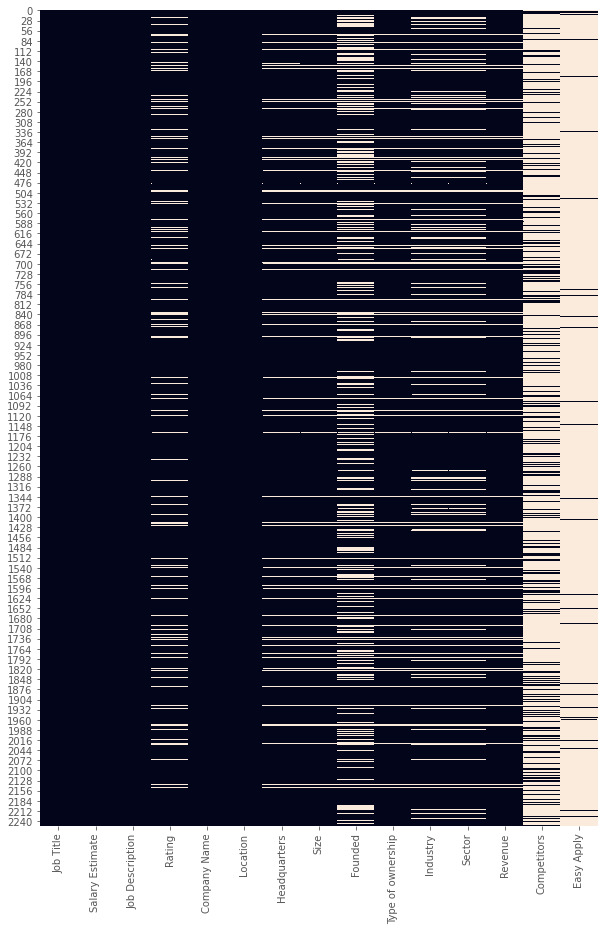

In [466]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize = (10, 15))
sns.heatmap(df.isnull(), cbar=False)

Удалим ненужные столбцы и строки с Nan значениями

In [467]:
df.columns[:]

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply'],
      dtype='object')

In [468]:
cols_to_drop = ['Easy Apply', 'Competitors', 'Founded']

In [469]:
df.drop(columns = cols_to_drop, inplace=True)
df.dropna(inplace=True)

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 0 to 2252
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          1854 non-null   object 
 1   Salary Estimate    1854 non-null   object 
 2   Job Description    1854 non-null   object 
 3   Rating             1854 non-null   float64
 4   Company Name       1854 non-null   object 
 5   Location           1854 non-null   object 
 6   Headquarters       1854 non-null   object 
 7   Size               1854 non-null   object 
 8   Type of ownership  1854 non-null   object 
 9   Industry           1854 non-null   object 
 10  Sector             1854 non-null   object 
 11  Revenue            1854 non-null   object 
dtypes: float64(1), object(11)
memory usage: 188.3+ KB


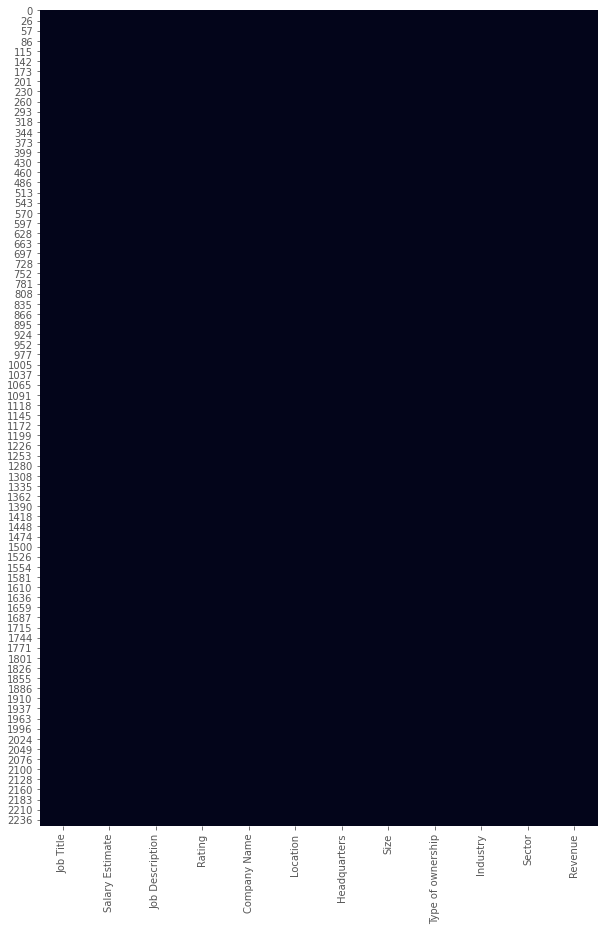

In [473]:
figure(figsize = (10, 15))
sns.heatmap(df.isnull(), cbar=False)

Данные отчищены, получим из столбца Salary Estimate числовые данные по заработной плате

In [474]:
df1 = df.copy()
df1.head(5)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD)
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD)
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD)
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD)


In [475]:

#Separate values for create new two fields from them:
df1['Company Name'],_ = df['Company Name'].str.split('\n',1).str
df1['Salary Estimate'],_= df['Salary Estimate'].str.split('(',1).str
df1['Min Salary'],df1['Max Salary']= df1['Salary Estimate'].str.split('-').str

# Created values Max Salary and Min Salary as well as data cleaning with strip methods from string class
# Replace withe spaces for nan values through the numpy.
clean_salary = lambda x: x.replace('', np.nan).str.strip().str.lstrip('$').str.rstrip('K').fillna(0).astype(int)
df1['Min Salary'] = clean_salary(df1['Min Salary'])
df1['Max Salary'] = clean_salary(df1['Max Salary'])
df1['Avg Salary'] = (df1['Min Salary']+df1['Max Salary']) /2
# Empty Field 'Salary Estimate' but created Max and Min salary.
df1 = df1.drop(['Salary Estimate'],axis = 1)

# Show 'df1' with the changes realized previously. 
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary,Avg Salary
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37,66,51.5
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37,66,51.5
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,37,66,51.5
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37,66,51.5
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37,66,51.5


In [476]:
df1.describe()

,Rating,Min Salary,Max Salary,Avg Salary
count,1854.000000,1854.000000,1854.000000,1854.000000
mean,3.737055,54.124595,89.896980,72.010787
std,0.641632,19.521118,29.592459,23.734498
min,1.000000,24.000000,38.000000,33.500000
25%,3.300000,41.000000,69.000000,58.000000
50%,3.700000,50.000000,87.000000,68.500000
75%,4.100000,63.000000,104.000000,80.500000
max,5.000000,113.000000,190.000000,150.000000


# Кластеризация данных

Посмотрим на вилки заработных плат

In [477]:
dfkluster = df1[['Min Salary','Max Salary']]

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Данные по зарплатам')

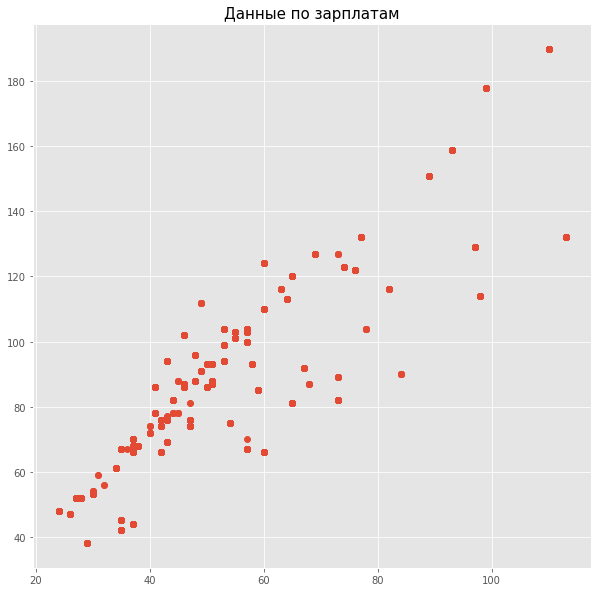

In [491]:
%pylab inline

# именно вот эта волшебная строчка делает наши графики
# довольно эстетичными с точки зрения ценителя хорошего дизайна
plt.style.use('ggplot')

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

# эта строчка просто задает размер графика
plt.figure(figsize=(10, 10))


# тут мы говорим, что хотим вывести 1-й график в 1-й строчке, в которой всего 3 графика
plt.subplot(111)
# и выводим его
plt.scatter(dfkluster['Min Salary'], dfkluster['Max Salary'], edgecolors='face')
plt.title(u"Данные по зарплатам", fontsize=15)



Ожидаемо видим линейную зависимость минимальной и максимальной предложенной заработной платы, кластеризируем точки на три типа: низкая, средняя, высокая

In [492]:
dataset = np.array(dfkluster)

 **K-means**

Cluster 0: 749
Cluster 1: 290
Cluster 2: 815


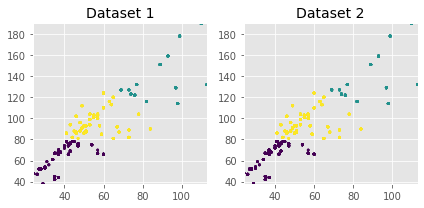

In [493]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

def cluster_plots(set1, set2, colours1 = 'gray', colours2 = 'gray', 
                  title1 = 'Dataset 1',  title2 = 'Dataset 2'):
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours1)
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
    fig.tight_layout()
    plt.show()



kmeans_dataset = cluster.KMeans(n_clusters=3, max_iter=500, 
                                 init='k-means++',n_init=50).fit_predict(dataset)
print(*["Cluster "+str(i)+": "+ str(sum(kmeans_dataset==i)) for i in range(3)], sep='\n')
cluster_plots(dataset, dataset, 
              kmeans_dataset, kmeans_dataset)

K-means достаточно неплохо разделил наши данные

**EM-алгоритм (Expectation–maximization algorithm)**

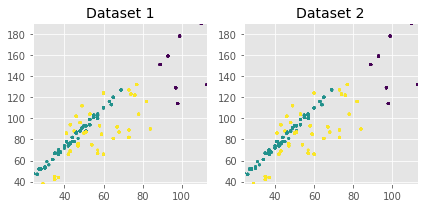

In [494]:
em_dataset = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(dataset)

cluster_plots(dataset, dataset, em_dataset.predict(dataset),  em_dataset.predict(dataset))

EM-алгоритм показал совершенно не тот результат, который нам нужен

**Hierarchical Clustering**

Dataset
Cluster 0: 418
Cluster 1: 749
Cluster 2: 687


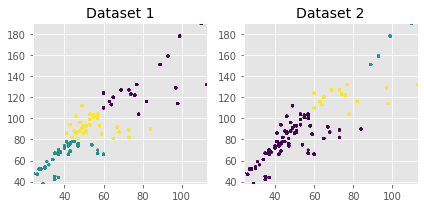

In [495]:

hc_dataset1 = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                              linkage='ward').fit_predict(dataset)
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                              linkage='average').fit_predict(dataset)
print("Dataset")
print(*["Cluster "+str(i)+": "+ str(sum(hc_dataset1==i)) for i in range(3)], sep='\n')
cluster_plots(dataset, dataset, hc_dataset1, hc_dataset2)

Алгоритм ward отработал хорошо, показал более сбалансированные классы, чем K-means

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 82 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


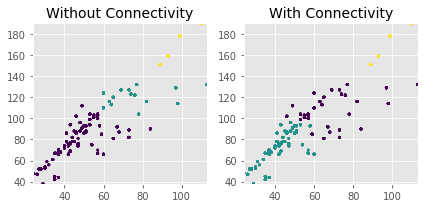

In [497]:
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                              linkage='complete').fit_predict(dataset)
connect = kneighbors_graph(dataset, n_neighbors=5, include_self=False)
hc_dataset2_connectivity = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                              linkage='complete',connectivity=connect).fit_predict(dataset)
cluster_plots(dataset, dataset,hc_dataset2,hc_dataset2_connectivity,
             title1='Without Connectivity', title2='With Connectivity')

Представленные выше варианты показали слишком большой кластер низких зарплат

**Meanshift**

Dataset1: 3 clusters
Dataset2: 3 clusters


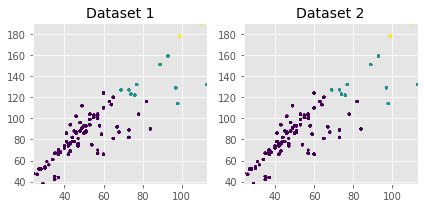

In [498]:
# implementing Mean Shift clustering in python
# auto-calculate bandwidths with estimate_bandwidth
bandwidths = [cluster.estimate_bandwidth(dataset, quantile=0.25) 
                         for dataset in [dataset, dataset]]
meanshifts = [cluster.MeanShift(bandwidth=band, bin_seeding=True).fit(dataset) 
              for dataset,band in zip([dataset,dataset],bandwidths)]
# print number of clusters for each dataset
print(*["Dataset"+str(i+1)+": "+ str(max(meanshifts[i].labels_)+1) + " clusters" 
        for i in range(2)], sep='\n')
# plot cluster output
cluster_plots(dataset, dataset, meanshifts[0].predict(dataset), meanshifts[1].predict(dataset))

Алгоритм построил крайне несбалансированные классы

# Использование моделей классификации

Используем результат работы алгоритма Hierarchical Clustering как целевого признака для моделей классификации

In [506]:
df2=df1.copy()
df2['Salary type'] = hc_dataset1
df2.head(10)

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary,Avg Salary,Salary type
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37,66,51.5,1
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37,66,51.5,1
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,37,66,51.5,1
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37,66,51.5,1
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37,66,51.5,1
5,Data Analyst,About Cubist\nCubist Systematic Strategies is ...,3.9,Point72,"New York, NY","Stamford, CT",1001 to 5000 employees,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,37,66,51.5,1
6,Business/Data Analyst (FP&A),Two Sigma is a different kind of investment ma...,4.4,Two Sigma,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,37,66,51.5,1
7,Data Science Analyst,Data Science Analyst\n\nJob Details\nLevel\nEx...,3.7,GNY Insurance Companies,"New York, NY","New York, NY",201 to 500 employees,Company - Private,Insurance Carriers,Insurance,$100 to $500 million (USD),37,66,51.5,1
8,Data Analyst,The Data Analyst is an integral member of the ...,4.0,DMGT,"New York, NY","London, United Kingdom",5001 to 10000 employees,Company - Public,Venture Capital & Private Equity,Finance,$1 to $2 billion (USD),37,66,51.5,1
9,"Data Analyst, Merchant Health",About Us\n\nRiskified is the AI platform power...,4.4,Riskified,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Research & Development,Business Services,Unknown / Non-Applicable,37,66,51.5,1


Посмотрим на распределение средних зарплат по кластерам, чтобы убедиться что данная кластеризация имеет смысл

Text(0.5, 1.0, 'Распределение зарплат по классам')

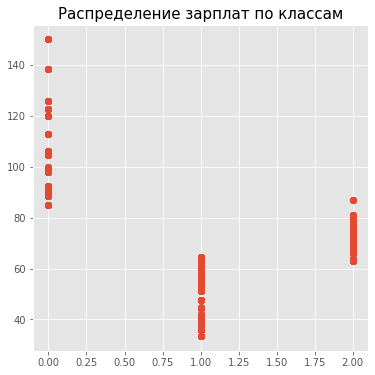

In [508]:
plt.figure(figsize=(6, 6))


# тут мы говорим, что хотим вывести 1-й график в 1-й строчке, в которой всего 3 графика
plt.subplot(111)
# и выводим его
plt.scatter(df2['Salary type'], df2['Avg Salary'], edgecolors='face')
plt.title(u"Распределение зарплат по классам", fontsize=15)

Отчистим данные от лишних столбцов и перекодируем признаки

In [511]:
cols_to_drop1 = ['Min Salary', 'Max Salary', 'Avg Salary','Job Title','Job Description','Company Name']

In [512]:
df2.drop(columns = cols_to_drop1, inplace=True)

In [513]:
from sklearn import preprocessing

def number_encode_features(init_df):
    result = init_df.copy() 
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: 
            encoders[column] = preprocessing.LabelEncoder() 
            result[column] = encoders[column].fit_transform(result[column]) 
    return result, encoders

df2, encoders = number_encode_features(df2)  
df2.head() 

,Rating,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Salary type
0,3.2,142,251,3,7,71,16,4,1
1,3.8,142,251,1,7,42,10,5,1
2,3.4,142,251,2,1,51,11,12,1
3,4.1,142,209,3,12,47,11,9,1
4,3.9,142,251,5,1,73,2,4,1


In [514]:
encoders

{'Headquarters': LabelEncoder(),
 'Industry': LabelEncoder(),
 'Location': LabelEncoder(),
 'Revenue': LabelEncoder(),
 'Sector': LabelEncoder(),
 'Size': LabelEncoder(),
 'Type of ownership': LabelEncoder()}

Выделим целевую переменную

In [515]:
y = np.array(df2['Salary type'])
del df2['Salary type']

print(y)
len(y)

[1 1 1 ... 0 0 0]


1854

Посмотрим описательную статистику наших признаков

In [516]:
df2.describe()

,Rating,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,3.737055,117.752427,218.056095,2.927184,2.347357,43.220604,8.646710,6.815534
std,0.641632,59.114702,113.982001,2.110183,2.844628,23.693728,4.484644,4.019174
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,56.000000,118.000000,1.000000,1.000000,19.000000,4.000000,3.000000
50%,3.700000,135.000000,251.000000,2.000000,1.000000,47.000000,10.000000,6.000000
75%,4.100000,170.000000,317.000000,5.000000,2.000000,61.000000,11.000000,11.000000
max,5.000000,230.000000,413.000000,7.000000,13.000000,87.000000,23.000000,12.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a49826908>,
      dtype=object)

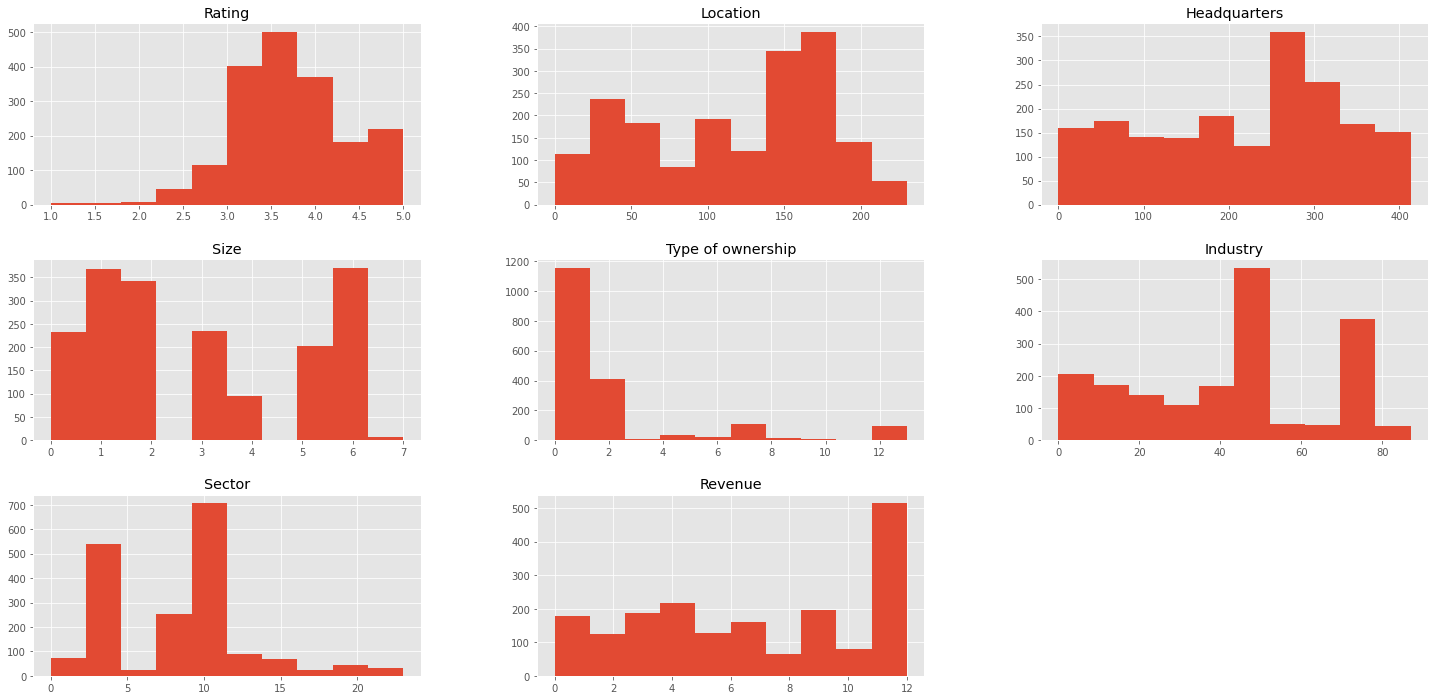

In [517]:
df2.hist(figsize=(25,12))

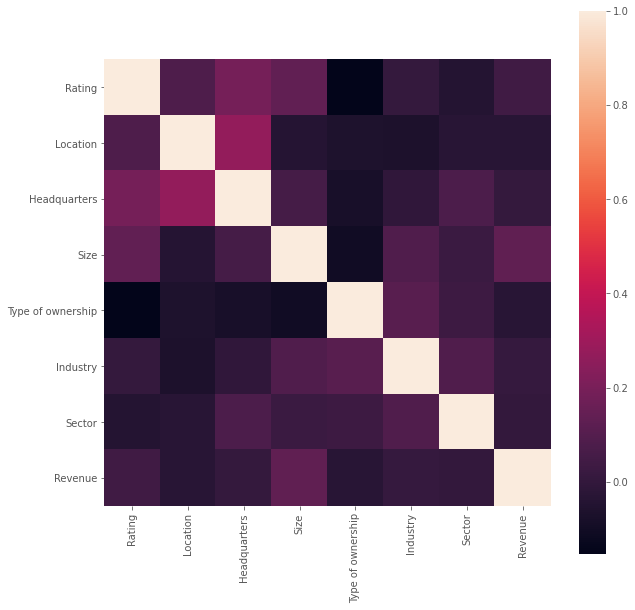

In [518]:
plt.subplots(figsize=(10,10))
df2, encoders = number_encode_features(df2)
sns.heatmap(df2.corr(), square=True)
plt.show()

Нормализуем данные и разделим выборку на обучающую и тестовую

In [519]:
from sklearn.preprocessing import scale
X = np.array(df2)
X = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)

X

array([[-0.83724004,  0.41028905,  0.28910524, ...,  1.172753  ,
         1.64010211, -0.70071457],
       [ 0.09812786,  0.41028905,  0.28910524, ..., -0.05152981,
         0.30184231, -0.45184009],
       [-0.52545074,  0.41028905,  0.28910524, ...,  0.32842002,
         0.52488561,  1.29028132],
       ...,
       [-1.30492399, -1.3325564 , -1.34317162, ...,  1.84821937,
        -1.03641749, -0.94958906],
       [-0.99313469, -1.3325564 ,  1.5264764 , ..., -0.60034625,
         0.52488561, -0.2029656 ],
       [-0.52545074, -1.48484387, -1.48358254, ..., -0.05152981,
         0.30184231, -0.45184009]])

In [520]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [521]:
X_train.shape, y_train.shape

((1575, 8), (1575,))

**SVM**

In [522]:
from sklearn.svm import SVC

In [523]:
alg = SVC()

grid = {'C': np.array(np.linspace(-5, 5, 10), dtype='float'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1, scoring = 'f1_macro')
gs.fit(X_train, y_train,)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.1s finished


({'C': 5.0, 'kernel': 'rbf'}, 0.396809449756666)

In [524]:
alg = SVC(C =  5, kernel = 'rbf')
alg.fit(X_train, y_train)
preds = alg.predict(X_test)

In [525]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.41      0.21      0.28        75
           1       0.42      0.53      0.47       109
           2       0.34      0.37      0.36        95

    accuracy                           0.39       279
   macro avg       0.39      0.37      0.37       279
weighted avg       0.39      0.39      0.38       279



Результаты слабые, модель не обладает предсказательной силой

**логистическая регрессия**

In [529]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight = 'balanced')

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

In [530]:
# опознал диагнозы 3,6, но по 2 диагнозу несколько хуже
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.37      0.64      0.47        75
           1       0.51      0.49      0.50       109
           2       0.39      0.19      0.26        95

    accuracy                           0.43       279
   macro avg       0.42      0.44      0.41       279
weighted avg       0.43      0.43      0.41       279



Модель тоже слабая

**knn**

In [531]:
from sklearn import dummy


knn = KNeighborsClassifier(n_neighbors=2) 

clf_knn = knn.fit(X_train, y_train)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_train)

In [532]:
predictions = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [533]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.32      0.40      0.35        75
           1       0.38      0.48      0.42       109
           2       0.31      0.16      0.21        95

    accuracy                           0.35       279
   macro avg       0.34      0.34      0.33       279
weighted avg       0.34      0.35      0.33       279



Модель еще хуже чем остальные

# Работа с текстовыми данными

В этом разделе попробуем оценить предсказательную возможность NLP моделей по описанию вакансии и названию должности. Подготовим датасет.

In [534]:
df3 = df1.copy()
df3['Salary type'] = hc_dataset1
df3.head(5)

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary,Avg Salary,Salary type
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37,66,51.5,1
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37,66,51.5,1
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,37,66,51.5,1
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37,66,51.5,1
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37,66,51.5,1


In [535]:
cols_to_drop2 = ['Rating', 'Company Name', 'Location','Headquarters','Size','Type of ownership','Industry','Sector','Revenue','Min Salary','Max Salary','Avg Salary']

In [536]:
df3.drop(columns = cols_to_drop2, inplace=True)

In [537]:
df3.head(3)

,Job Title,Job Description,Salary type
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,1
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,1
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,1


In [538]:
dfplt = df3.groupby('Salary type').count()[['Job Title']]
dfplt

,Job Title
Salary type,
0,418
1,749
2,687


Опробуем работу разных моделей по описанию работы

In [678]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
vectorizer.fit(df3['Job Description'])


CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [679]:
len(vectorizer.vocabulary_)

18353

In [680]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df3, test_size=0.2, shuffle=False)

In [681]:
df_train.shape, df_test.shape

((1483, 3), (371, 3))

In [682]:
X_train = vectorizer.transform(df_train['Job Description'])
X_test = vectorizer.transform(df_test['Job Description'])

In [684]:
X_train.shape, X_test.shape

((1483, 18353), (371, 18353))

**Count vectorizacion**

In [685]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB

In [686]:
clf1 = MultinomialNB().fit(X_train, df_train['Salary type'])

In [687]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('0', '1','2')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))

# отобразим 20 топовых слов
show_top(clf1, vectorizer, 20)

0: team will years business as work analyst is on skills or for experience the data with of in to and
1: will an on years business skills analyst as is work or experience for with the in of data and to
2: will be years business skills on analyst as work is or experience for the of in with to data and


In [688]:

from sklearn.metrics import classification_report

predicts = clf.predict(X_train)
# train
print(classification_report(df_train['Salary type'], predicts, target_names=['высокая','низкая','средняя']))

              precision    recall  f1-score   support

     высокая       0.89      0.62      0.73       319
      низкая       0.81      0.94      0.87       622
     средняя       0.86      0.85      0.86       542

    accuracy                           0.84      1483
   macro avg       0.85      0.81      0.82      1483
weighted avg       0.85      0.84      0.84      1483



In [689]:
predicts = clf.predict(X_test)
print(classification_report(df_test['Salary type'], predicts, target_names=['высокая','низкая','средняя']))

              precision    recall  f1-score   support

     высокая       0.38      0.10      0.16        99
      низкая       0.38      0.44      0.41       127
     средняя       0.42      0.57      0.48       145

    accuracy                           0.40       371
   macro avg       0.39      0.37      0.35       371
weighted avg       0.39      0.40      0.37       371



In [690]:
count_vect = CountVectorizer(binary=False).fit(df3['Job Description'])

X_train_counts = count_vect.transform(df_train['Job Description'])
X_test_counts = count_vect.transform(df_test['Job Description'])

In [691]:
# представление 42го отзыва
dict(zip(count_vect.inverse_transform(X_train_counts[182])[0], X_train_counts[0].data))

{'122': 1,
 '150': 1,
 '2020': 1,
 '23': 1,
 'about': 1,
 'acceptable': 1,
 'across': 1,
 'action': 1,
 'activities': 2,
 'administration': 1,
 'advancement': 4,
 'affirmative': 1,
 'again': 1,
 'against': 2,
 'age': 1,
 'all': 2,
 'also': 1,
 'an': 1,
 'analysis': 1,
 'analyst': 1,
 'analystbased': 1,
 'and': 1,
 'answering': 1,
 'any': 1,
 'applicant': 1,
 'applicants': 1,
 'application': 1,
 'applying': 6,
 'are': 4,
 'art': 5,
 'as': 1,
 'assigned': 61,
 'assists': 1,
 'assure': 3,
 'at': 2,
 'auditing': 2,
 'audits': 9,
 'authorities': 1,
 'banknote': 5,
 'banks': 1,
 'basis': 2,
 'be': 2,
 'because': 1,
 'both': 3,
 'branch': 1,
 'branches': 1,
 'brinks': 1,
 'btc': 1,
 'business': 1,
 'businesses': 1,
 'by': 1,
 'candidates': 5,
 'career': 1,
 'chain': 1,
 'challenging': 1,
 'characteristic': 1,
 'charges': 1,
 'choice': 4,
 'class': 1,
 'closely': 1,
 'color': 1,
 'committed': 1,
 'communication': 1,
 'communications': 3,
 'communities': 1,
 'company': 1,
 'complete': 2,
 'comp

In [692]:
# обучим
clf = MultinomialNB().fit(X_train_counts, df_train['Salary type'])

In [693]:
# train
predicts = clf.predict(X_train_counts)
print(classification_report(df_train['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       319
           1       0.83      0.92      0.87       622
           2       0.86      0.83      0.84       542

    accuracy                           0.84      1483
   macro avg       0.85      0.82      0.83      1483
weighted avg       0.85      0.84      0.84      1483



In [694]:
# test
# конвертируем тестовые слова
predicts = clf.predict(count_vect.transform(df_test['Job Description']))
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.38      0.14      0.21        99
           1       0.37      0.40      0.39       127
           2       0.40      0.54      0.46       145

    accuracy                           0.39       371
   macro avg       0.38      0.36      0.35       371
weighted avg       0.39      0.39      0.37       371



In [695]:
!pip install --user -U nltk

Requirement already up-to-date: nltk in /root/.local/lib/python3.6/site-packages (3.5)


In [696]:

import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [697]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [698]:

from nltk.corpus import stopwords
stopWords = stopwords.words('english')

In [699]:
count_vect = CountVectorizer(stop_words=stopWords + list(ENGLISH_STOP_WORDS), binary=False).fit(df3['Job Description'])

In [757]:

X_train_counts = count_vect.transform(df_train['Job Description'])
X_test_counts = count_vect.transform(df_test['Job Description'])

In [758]:
clf1 = MultinomialNB().fit(X_train_counts, df_train['Salary type'])

In [759]:

predicts = clf1.predict(X_test_counts)
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.41      0.30      0.34        74
           1       0.52      0.60      0.55       154
           2       0.47      0.46      0.47       143

    accuracy                           0.49       371
   macro avg       0.47      0.45      0.46       371
weighted avg       0.48      0.49      0.48       371



**TF-IDF**

In [704]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(stop_words=stopWords + list(ENGLISH_STOP_WORDS))
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(df3['Job Description'])

In [705]:
X_train_vectors = vectorizer.transform(df_train['Job Description'])
X_test_vectors = vectorizer.transform(df_test['Job Description'])

In [706]:
num = 1300
X_train_vectors[num].data

array([0.31618079, 0.06192752, 0.03941734, 0.16659534, 0.07715219,
       0.20944769, 0.08829654, 0.20099603, 0.188252  , 0.14190096,
       0.12478183, 0.24921017, 0.14419715, 0.06439507, 0.12708231,
       0.07549733, 0.12560079, 0.09019863, 0.14691644, 0.15290329,
       0.12748529, 0.10384745, 0.04728341, 0.15648309, 0.07800429,
       0.06455992, 0.15647068, 0.05481707, 0.12020839, 0.1147047 ,
       0.05732542, 0.12601701, 0.11729904, 0.1209333 , 0.1346785 ,
       0.08099174, 0.14190096, 0.0724784 , 0.11115128, 0.06870225,
       0.13263068, 0.07818142, 0.1156659 , 0.08837391, 0.188252  ,
       0.10662743, 0.06659627, 0.28130195, 0.10202725, 0.17784003,
       0.0967482 , 0.11828359, 0.12539438, 0.10315458, 0.07673734,
       0.11501644])

In [707]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['with', 'on', 'management', 'job', 'working', 'responsibilities',
       'new', 'communication', 'develop', 'excel', 'qualifications',
       'and', 'to', 'not', 'description', 'experience', 'stakeholders',
       'customer', 'product', 'but', 'closely', 'areas', 'operational',
       'cross', 'document', 'limited', 'additional', 'data', 'in',
       'basic', 'maintaining', 'identifying', 'sales', 'automation',
       'public', 'includes', 'reporting', 'or', 'details', 'google',
       'setting', 'excellence', 'roles', 'processes', 'preparation',
       'millions', 'of', 'train', 'client', 'cultural', 'sheets',
       'speaking', 'streamlining', 'rows', 'comment', 'year'],
      dtype='<U46')

In [708]:
clf = MultinomialNB().fit(X_train_vectors, df_train['Salary type'])

In [709]:
show_top(clf, vectorizer, 20)

0: team management work on we skills our as is business or for experience with in of the data to and
1: skills on analysis as we you work our is business experience for or with in of the data to and
2: analysis skills on work you as we our is business or experience for with in of data the to and


In [710]:
predicts = clf.predict(vectorizer.transform(df_test['Job Description']))
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.34      0.93      0.50       127
           2       0.45      0.07      0.12       145

    accuracy                           0.35       371
   macro avg       0.26      0.33      0.21       371
weighted avg       0.29      0.35      0.22       371



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Опробуем работу разных моделей по названию позиции

In [711]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
vectorizer.fit(df3['Job Title'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [712]:
len(vectorizer.vocabulary_)

913

In [713]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df3, test_size=0.2, shuffle=True)

In [714]:
df_train.shape, df_test.shape

((1483, 3), (371, 3))

In [715]:
X_train = vectorizer.transform(df_train['Job Title'])
X_test = vectorizer.transform(df_test['Job Title'])

In [716]:
X_train.shape, X_test.shape

((1483, 913), (371, 913))

In [717]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB

In [718]:
clf = MultinomialNB().fit(X_train, df_train['Salary type'])

In [719]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('0', '1','2')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))

# отобразим 20 топовых слов
show_top(clf, vectorizer, 20)

0: warehouse research manager management systems marketing quality operations financial master healthcare analytics lead reporting and business sr senior analyst data
1: science bi operations management ii sql with healthcare reporting governance financial analytics and quality junior sr business senior analyst data
2: operations governance warehouse ii security programmer engineer with junior management lead reporting quality and analytics sr business senior analyst data


In [720]:

from sklearn.metrics import classification_report

predicts = clf.predict(X_train)
# train
print(classification_report(df_train['Salary type'], predicts, target_names=['высокая','низкая','средняя']))

              precision    recall  f1-score   support

     высокая       0.88      0.26      0.40       344
      низкая       0.56      0.86      0.67       595
     средняя       0.67      0.57      0.62       544

    accuracy                           0.61      1483
   macro avg       0.70      0.56      0.56      1483
weighted avg       0.67      0.61      0.59      1483



In [721]:
predicts = clf.predict(X_test)
print(classification_report(df_test['Salary type'], predicts, target_names=['высокая','низкая','средняя']))

              precision    recall  f1-score   support

     высокая       0.17      0.05      0.08        74
      низкая       0.47      0.68      0.55       154
     средняя       0.44      0.38      0.41       143

    accuracy                           0.44       371
   macro avg       0.36      0.37      0.35       371
weighted avg       0.40      0.44      0.40       371



In [722]:
count_vect = CountVectorizer(binary=False).fit(df3['Job Title'])

X_train_counts = count_vect.transform(df_train['Job Title'])
X_test_counts = count_vect.transform(df_test['Job Title'])

In [723]:
# представление 42го отзыва
dict(zip(count_vect.inverse_transform(X_train_counts[182])[0], X_train_counts[0].data))

{'analyst': 1, 'data': 1, 'growth': 1}

In [724]:
clf = MultinomialNB().fit(X_train_counts, df_train['Salary type'])

In [725]:
# train
predicts = clf.predict(X_train_counts)
print(classification_report(df_train['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.87      0.26      0.40       344
           1       0.56      0.85      0.67       595
           2       0.66      0.58      0.62       544

    accuracy                           0.61      1483
   macro avg       0.70      0.56      0.56      1483
weighted avg       0.67      0.61      0.59      1483



In [726]:
# test
# конвертируем тестовые слова
predicts = clf.predict(count_vect.transform(df_test['Job Title']))
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.17      0.05      0.08        74
           1       0.46      0.64      0.54       154
           2       0.42      0.38      0.40       143

    accuracy                           0.43       371
   macro avg       0.35      0.36      0.34       371
weighted avg       0.39      0.43      0.39       371



In [727]:

import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [728]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [729]:

from nltk.corpus import stopwords
stopWords = stopwords.words('english')

In [730]:
count_vect = CountVectorizer(stop_words=stopWords + list(ENGLISH_STOP_WORDS), binary=False).fit(df3['Job Description'])

In [731]:

X_train_counts = count_vect.transform(df_train['Job Title'])
X_test_counts = count_vect.transform(df_test['Job Title'])

In [732]:
clf = MultinomialNB().fit(X_train_counts, df_train['Salary type'])

In [733]:

predicts = clf.predict(X_test_counts)
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.45      0.73      0.55       154
           2       0.45      0.37      0.40       143

    accuracy                           0.44       371
   macro avg       0.30      0.37      0.32       371
weighted avg       0.36      0.44      0.39       371



In [734]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(stop_words=stopWords + list(ENGLISH_STOP_WORDS))
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(df3['Job Title'])

In [735]:
X_train_vectors = vectorizer.transform(df_train['Job Title'])
X_test_vectors = vectorizer.transform(df_test['Job Title'])

In [736]:
num = 1300
X_train_vectors[num].data

array([0.90576973, 0.29948922, 0.29981229])

In [737]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['data', 'analyst', 'senior'], dtype='<U16')

In [738]:
clf2 = MultinomialNB().fit(X_train_vectors, df_train['Salary type'])

In [739]:
show_top(clf2, vectorizer, 20)

0: research iii junior governance systems master marketing financial quality operations healthcare analytics reporting and lead sr business senior analyst data
1: iii management operations product financial science and ii sql healthcare analytics reporting governance sr quality junior business senior analyst data
2: marketing warehouse intelligence governance programmer security engineer ii and analytics quality management lead reporting junior sr business senior data analyst


In [740]:
predicts = clf2.predict(vectorizer.transform(df_test['Job Title']))
print(classification_report(df_test['Salary type'], predicts))

              precision    recall  f1-score   support

           0       0.23      0.04      0.07        74
           1       0.44      0.64      0.52       154
           2       0.41      0.38      0.39       143

    accuracy                           0.42       371
   macro avg       0.36      0.35      0.33       371
weighted avg       0.39      0.42      0.38       371



Значимых результатов по итогам работы моделей добиться не удалось